In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
import pickle

In [ ]:
jkt_merged = pd.read_csv('/content/drive/MyDrive/Telkom University/Scraping Web Rumah123/final/Jakarta_merged.csv')
bdg_merged = pd.read_csv('/content/drive/MyDrive/Telkom University/Scraping Web Rumah123/final/Bandung_merged.csv')
ygy_merged = pd.read_csv('/content/drive/MyDrive/Telkom University/Scraping Web Rumah123/final/Yogya_merged.csv')
sby_merged = pd.read_csv('/content/drive/MyDrive/Telkom University/Scraping Web Rumah123/final/Surabaya_merged.csv')
bali_merged = pd.read_csv('/content/drive/MyDrive/Telkom University/Scraping Web Rumah123/final/Bali_merged.csv')

In [ ]:
def rupiah_formatter(x, pos):
    if x >= 1e9:
        return f'Rp {x/1e9:.1f} M'
    else:
        return f'Rp {x/1e6:.0f} Jt'

In [ ]:
def log_rupiah_formatter(x, pos):
    if x >= 1e9:
        return f'Rp {x/1e9:.1f} M'
    elif x >= 1e6:
        return f'Rp {x/1e6:.0f} Jt'
    else:
        return f'Rp {x:.0f}'

In [ ]:
def get_histplot(df, **kwargs):
  features = ['Luas Tanah', 'Luas Bangunan', 'Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai', 'Harga']

  for col in features:
    plt.figure()
    sns.histplot(df[col], bins=kwargs.get('bins', 'auto'), kde=True, log_scale=kwargs.get('log_scale', False))
    plt.title(col)
    plt.show()

In [ ]:
def get_boxplot(df):
  features = ['Luas Tanah', 'Luas Bangunan', 'Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai', 'Harga']

  for col in features:
    plt.figure()
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

In [ ]:
def get_corr(df):
  features = ['Luas Tanah', 'Luas Bangunan', 'Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai', 'Harga']
  sns.heatmap(df[features].corr(), annot=True)
  plt.xticks(rotation=45)
  plt.show()

In [ ]:
def save_corr(df, title):
  features = ['Luas Tanah', 'Luas Bangunan', 'Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai', 'Harga']
  # plt.figure(figsize=(8, 6))
  sns.heatmap(df[features].corr(), annot=True)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.savefig(f'{title}_corr.png')

In [ ]:
def save_scatter(df, x, y, title):
    # Plot
    ax = sns.scatterplot(data=df, x=x, y=y, hue='Category')

    # Apply formatter
    ax.yaxis.set_major_formatter(FuncFormatter(rupiah_formatter))

    # Axis labels
    ax.set_ylabel(y)
    ax.set_xlabel(f'{x} (m$^2$)')
    plt.tight_layout()
    plt.savefig(f'{title}_scatter.png')
    plt.show()

In [ ]:
def save_scatterlog(df, x, y, title):
    # plt.figure(figsize=(8, 6))
    ax = sns.scatterplot(data=df, x=x, y=y, hue='Category')

    # Set y-axis to log scale
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(FuncFormatter(log_rupiah_formatter))

    # Dynamically generate log ticks
    min_y = df[y].min()
    max_y = df[y].max()

    # Round min and max to reasonable powers of 10
    min_tick = 10 ** int(np.floor(np.log10(min_y)))
    # Instead of rounding max up, add 10–20% buffer
    max_tick = max_y * 1.2

    # Create log-spaced ticks (base 10)
    log_ticks = np.logspace(np.log10(min_tick), np.log10(max_tick), num=9)
    ax.set_yticks(log_ticks)

    # Labels and layout
    ax.set_ylabel(y)
    ax.set_xlabel(f'{x} (m$^2$)')
    plt.tight_layout()
    plt.savefig(f'{title}_scatterlog.png')
    plt.show()

In [ ]:
def get_iqr(df):
  features = ['Luas Tanah', 'Luas Bangunan', 'Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai', 'Harga']
  iqr_dict = {}

  for col in features:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    if col == 'Harga':
      lower_bound = q1 - (1.5 * iqr)
      upper_bound = q3 + (1.5 * iqr)
      iqr_dict[col] = [lower_bound, upper_bound]
    else:
      lower_bound = q1 - (1.5 * iqr)
      upper_bound = q3 + (1.5 * iqr)
      iqr_dict[col] = [max(1, np.floor(lower_bound)), np.ceil(upper_bound)]

  return iqr_dict

In [ ]:
def get_outlier(df):
  features = ['Luas Tanah', 'Luas Bangunan', 'Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai', 'Harga']
  iqr_dict = get_iqr(df)
  outlier_indices = []

  for col in features:
    lower_bound = iqr_dict[col][0]
    upper_bound = iqr_dict[col][1]
    filt = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_indices.extend(df.loc[filt, col].index.tolist())

    num_outliers = df.loc[filt, col].shape[0]
    print(f'{col} -- found outliers: {num_outliers} ')

  outlier_indices = list(set(outlier_indices))

  print('\n\ndf with outliers')
  print(df.loc[outlier_indices, features])

In [ ]:
def split_scaled(df, scaler_robust, scaler_minmax):
    new_df = df.copy()
    X = new_df.drop(columns=['Category', 'Harga'])
    y = new_df['Harga']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[['Luas Tanah', 'Luas Bangunan']] = scaler_robust.fit_transform(X_train[['Luas Tanah', 'Luas Bangunan']])
    X_train_scaled[['Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai']] = scaler_minmax.fit_transform(X_train[['Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai']])

    X_test_scaled[['Luas Tanah', 'Luas Bangunan']] = scaler_robust.transform(X_test[['Luas Tanah', 'Luas Bangunan']])
    X_test_scaled[['Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai']] = scaler_minmax.transform(X_test[['Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai']])

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    return X_train_scaled, X_test_scaled, y_train_log, y_test_log

In [ ]:
def scale_feature(scaler_robust, scaler_minmax, list):
  new_list = list.copy()
  series_scaled = pd.DataFrame([new_list])
  series_scaled.columns = ['Luas Tanah', 'Luas Bangunan', 'Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai', 'Harga']

  series_scaled[['Luas Tanah', 'Luas Bangunan']] = scaler_robust.transform(series_scaled[['Luas Tanah', 'Luas Bangunan']])
  series_scaled[['Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai']] = scaler_minmax.transform(series_scaled[['Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai']])
  series_scaled['Harga'] = np.log1p(series_scaled['Harga'])

  return series_scaled

In [ ]:
def inverse_scale_feature(scaler_robust, scaler_minmax, series):
  new_list = series.copy()
  series_inversed = pd.DataFrame([new_list])
  series_inversed.columns = ['Luas Tanah', 'Luas Bangunan', 'Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai']

  series_inversed[['Luas Tanah', 'Luas Bangunan']] = scaler_robust.inverse_transform(series_inversed[['Luas Tanah', 'Luas Bangunan']])
  series_inversed[['Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai']] = scaler_minmax.inverse_transform(series_inversed[['Kamar Tidur', 'Kamar Mandi', 'Jumlah Lantai']])

  return series_inversed

In [ ]:
def get_model_summary(model, X_test, y_test):
  y_pred = model.predict(X_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print(f"MAE: {mae}")
  print(f"MSE: {mse}")
  print(f"R-squared: {r2}")
  print("")

  errors = abs(y_test - y_pred)
  print("Error for cheapest house:", np.min(errors))
  print("Error for most expensive house:", np.max(errors))
  print("")

  mape = (abs(y_test - y_pred) / y_test).mean() * 100
  print(f"MAPE: {mape:.2f}%")

In [ ]:
def get_model_summary_scaled(model, X_test, y_test_log):
    y_pred_log = model.predict(X_test)

    # Convert back to original scale
    y_test = np.expm1(y_test_log)
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")
    print("")

    errors = abs(y_test - y_pred)
    print("Error for cheapest house:", np.min(errors))
    print("Error for most expensive house:", np.max(errors))
    print("")

    mape = (errors / y_test).mean() * 100
    print(f"MAPE: {mape:.2f}%")

In [ ]:
def clean_col(df):
  new_df = df.copy()

  new_df.drop(columns=['Harga', 'nominal', 'satuan'], inplace=True)
  new_df.rename(columns={'converted': 'Harga'}, inplace=True)
  return new_df

### **Jakarta**

In [ ]:
jkt_merged

Luas Tanah  Luas Bangunan  Kamar Tidur  Kamar Mandi  Jumlah Lantai  \
0            20             31            2            2              2   
1            21             41            2            2              2   
2            22             43            2            2              2   
3            21             41            2            2              2   
4            20             39            2            2              2   
..          ...            ...          ...          ...            ...   
936         397            350            4            4              2   
937         440            400            4            4              2   
938         488            210            4            4              2   
939         207            180            4            4              2   
940         265            400            4            4              2   

    Category           Harga  nominal  satuan     converted  
0        Low     Rp 422 Juta    422.0    Juta  4.220000e+08  
1        Low     Rp 457 Juta    457.0    Juta  4.570000e+08  
2        Low     Rp 477 Juta    477.0    Juta  4.770000e+08  
3        Low     Rp 474 Juta    474.0    Juta  4.740000e+08  
4        Low     Rp 458 Juta    458.0    Juta  4.580000e+08  
..       ...             ...      ...     ...           ...  
936   Luxury    Rp 17 Miliar     17.0  Miliar  1.700000e+10  
937   Luxury   Rp 9,6 Miliar      9.6  Miliar  9.600000e+09  
938   Luxury    Rp 16 Miliar     16.0  Miliar  1.600000e+10  
939   Luxury    Rp 12 Miliar     12.0  Miliar  1.200000e+10  
940   Luxury  Rp 15,5 Miliar     15.5  Miliar  1.550000e+10  

[941 rows x 10 columns]

In [ ]:
filt = (jkt_merged['Luas Tanah'] == 1) | (jkt_merged['Luas Bangunan'] == 1)
jkt_merged[filt].index

Index([], dtype='int64')

In [ ]:
jkt_merged = clean_col(jkt_merged)

In [ ]:
jkt_merged.columns

Index(['Luas Tanah', 'Luas Bangunan', 'Kamar Tidur', 'Kamar Mandi',
       'Jumlah Lantai', 'Category', 'Harga'],
      dtype='object')

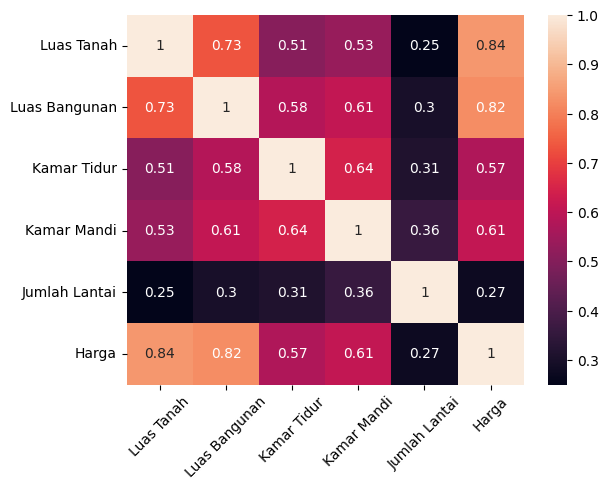

In [ ]:
get_corr(jkt_merged)

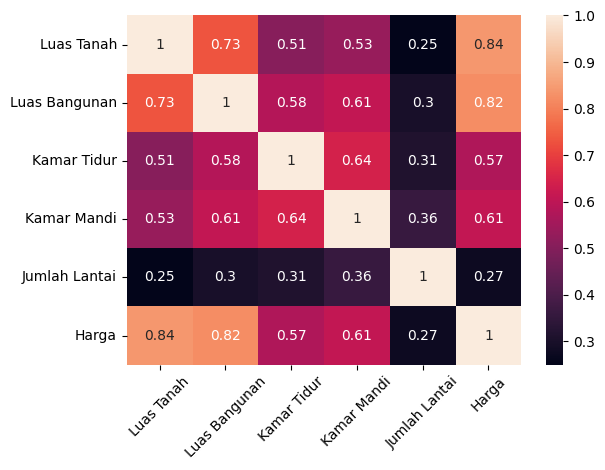

In [ ]:
save_corr(jkt_merged, 'jkt')

In [ ]:
X = jkt_merged.drop(columns=['Category', 'Harga'])
y = jkt_merged['Harga']

In [ ]:
jkt_robust = RobustScaler()
jkt_minmax = MinMaxScaler()

In [ ]:
X_train_scaled, X_test_scaled, y_train_log, y_test_log = split_scaled(jkt_merged, jkt_robust, jkt_minmax)

In [ ]:
jkt_xgb =  XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

In [ ]:
jkt_gridsearch = GridSearchCV(
      estimator=jkt_xgb,
      param_grid=param_grid,
      cv=10,
      scoring='neg_mean_squared_error',
      n_jobs=-1,
      verbose=2
  )

In [ ]:
jkt_gridsearch.fit(X_train_scaled, y_train_log)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
jkt_bestmodel = jkt_gridsearch.best_estimator_

In [ ]:
get_model_summary_scaled(jkt_bestmodel, X_test_scaled, y_test_log)

MAE: 1282438361.9047616
MSE: 5.459775352665478e+18
R-squared: 0.7742564897189954

Error for cheapest house: 2206783.999999225
Error for most expensive house: 10524464127.999992

MAPE: 28.63%


In [ ]:
with open('jkt_robust.pkl', 'wb') as f:
  pickle.dump(jkt_robust, f)

with open('jkt_minmax.pkl', 'wb') as f:
  pickle.dump(jkt_minmax, f)

with open('jkt_xgb.pkl', 'wb') as f:
  pickle.dump(jkt_bestmodel, f)

In [ ]:
jkt_merged.head()

Luas Tanah  Luas Bangunan  Kamar Tidur  Kamar Mandi  Jumlah Lantai  \
0          20             31            2            2              2   
1          21             41            2            2              2   
2          22             43            2            2              2   
3          21             41            2            2              2   
4          20             39            2            2              2   

  Category        Harga  
0      Low  422000000.0  
1      Low  457000000.0  
2      Low  477000000.0  
3      Low  474000000.0  
4      Low  458000000.0

<Axes: xlabel='Luas Tanah', ylabel='Harga'>

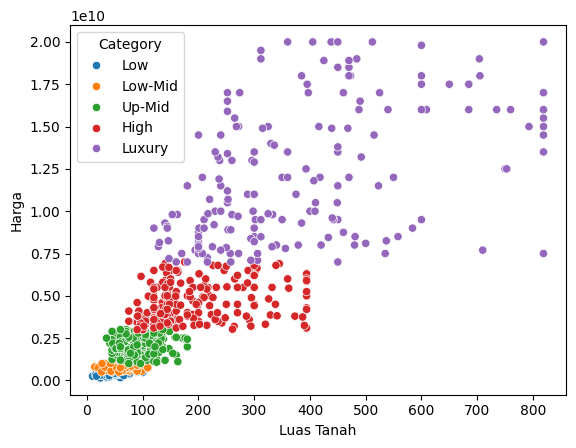

In [ ]:
sns.scatterplot(data=jkt_merged, x='Luas Tanah', y='Harga', hue='Category')

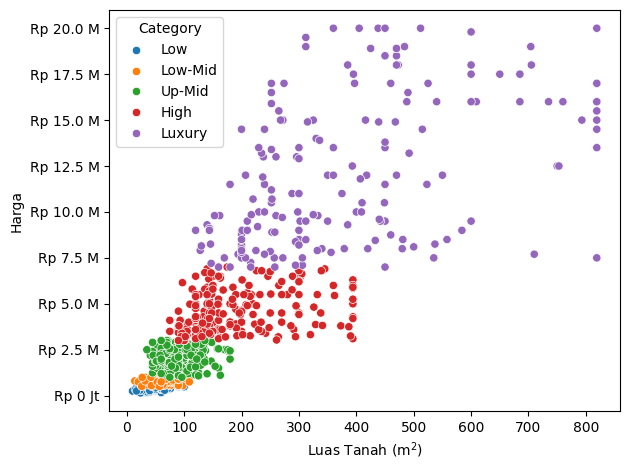

In [ ]:
save_scatter(jkt_merged, 'Luas Tanah', 'Harga', 'jkt_LT')

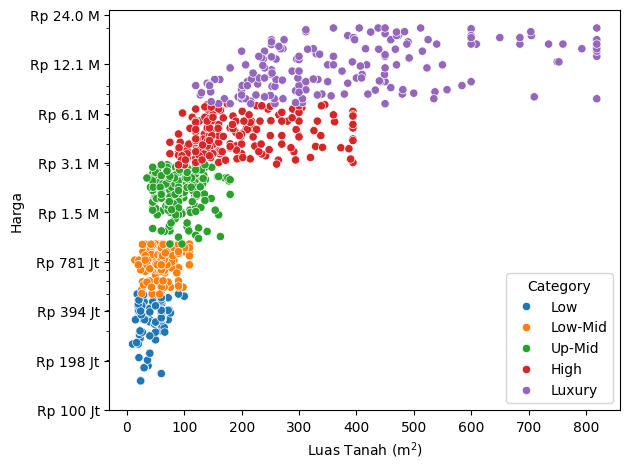

In [ ]:
save_scatterlog(jkt_merged, 'Luas Tanah', 'Harga', 'jkt_LT')

In [ ]:
jkt_merged[jkt_merged['Category'] == 'Luxury'].min()

Luas Tanah                120
Luas Bangunan             156
Kamar Tidur                 2
Kamar Mandi                 1
Jumlah Lantai               2
Category               Luxury
Harga            7000000000.0
dtype: object

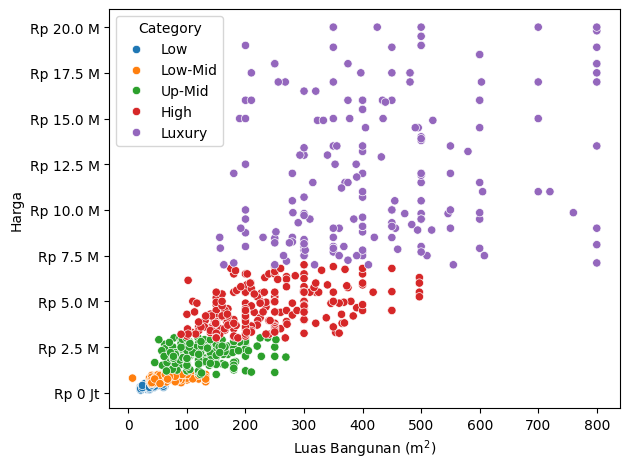

In [ ]:
save_scatter(jkt_merged, 'Luas Bangunan', 'Harga', 'jkt_LB')

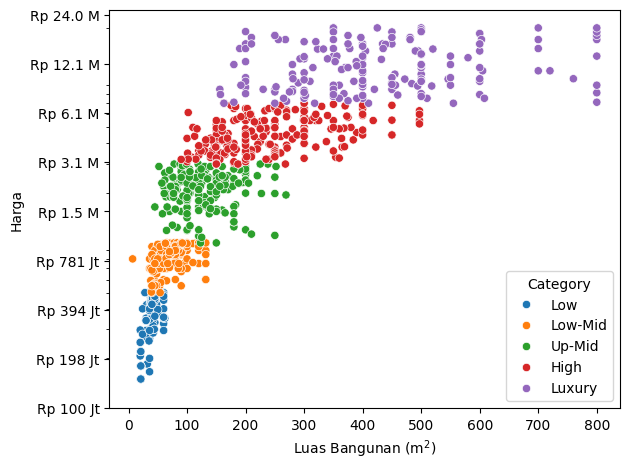

In [ ]:
save_scatterlog(jkt_merged, 'Luas Bangunan', 'Harga', 'jkt_LB')

#### test

In [ ]:
get_outlier(jkt_merged)

Luas Tanah -- found outliers: 72 
Luas Bangunan -- found outliers: 30 
Kamar Tidur -- found outliers: 0 
Kamar Mandi -- found outliers: 20 
Jumlah Lantai -- found outliers: 160 
Harga -- found outliers: 76 


df with outliers
     Luas Tanah  Luas Bangunan  Kamar Tidur  Kamar Mandi  Jumlah Lantai  \
27           24             43            2            2              1   
30           30             60            2            2              1   
32           72             45            2            1              1   
34           20             40            2            2              1   
38           20             38            2            2              1   
..          ...            ...          ...          ...            ...   
934         325            760            4            4              2   
936         397            350            4            4              2   
937         440            400            4            4              2   
938         488         

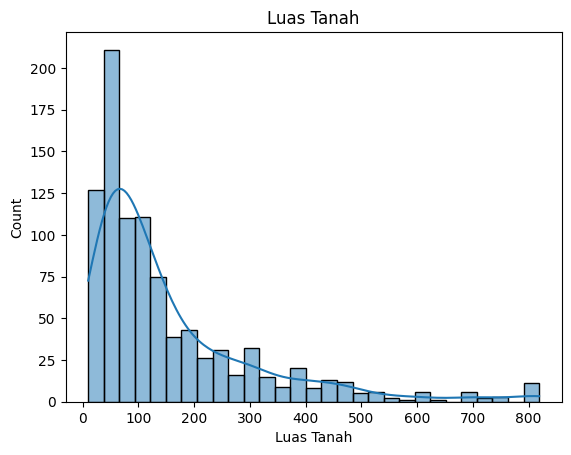

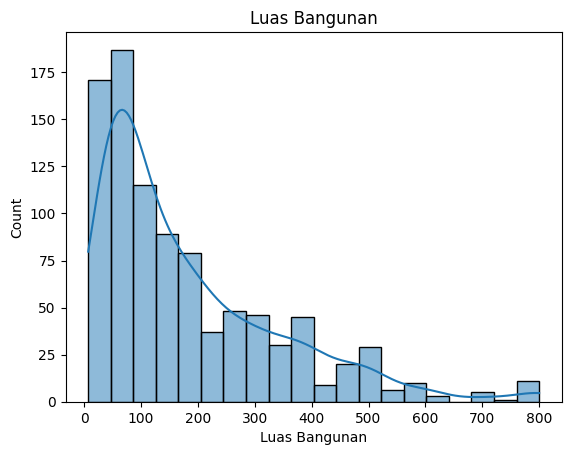

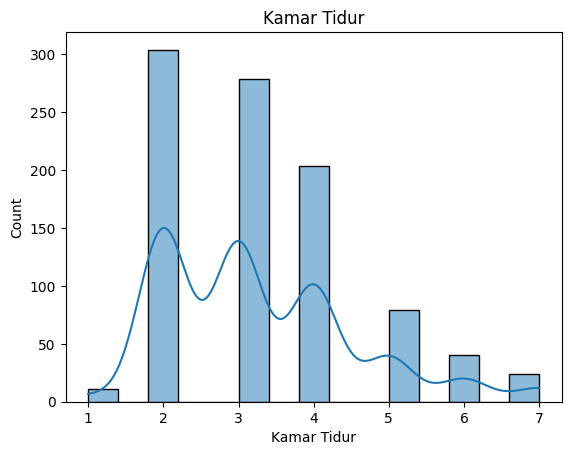

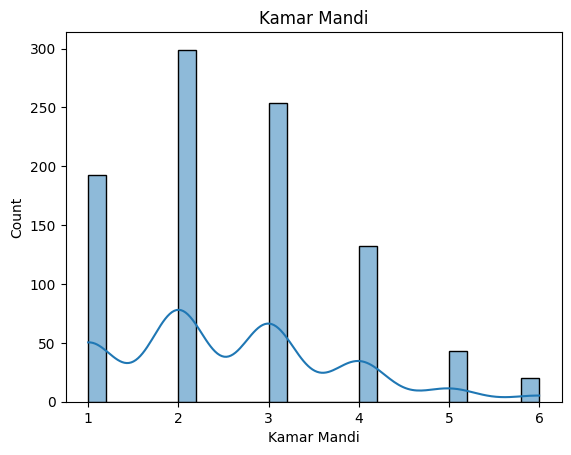

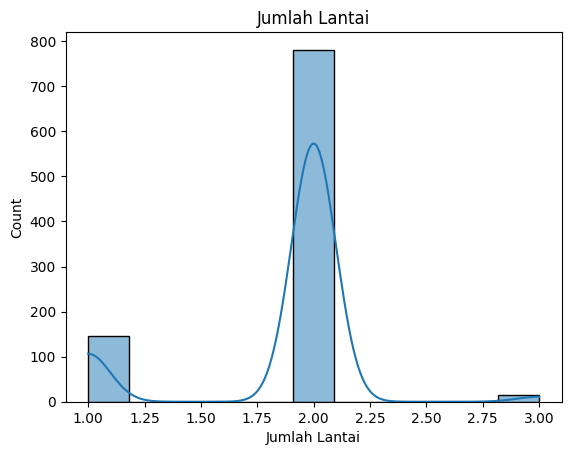

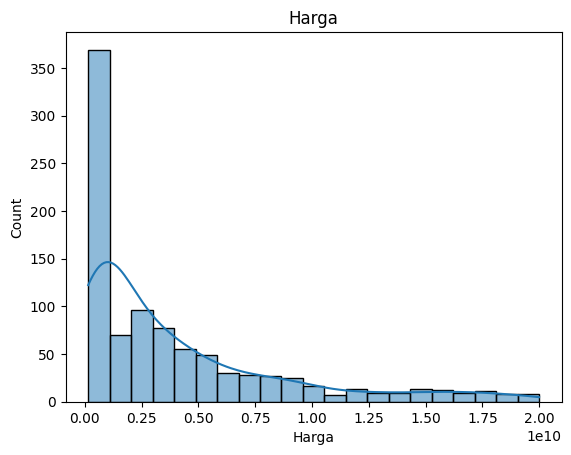

In [ ]:
get_histplot(jkt_merged)

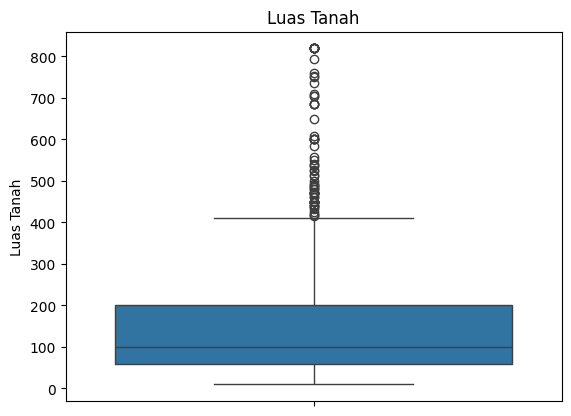

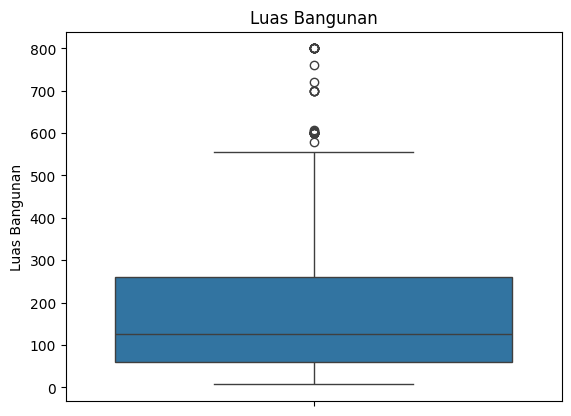

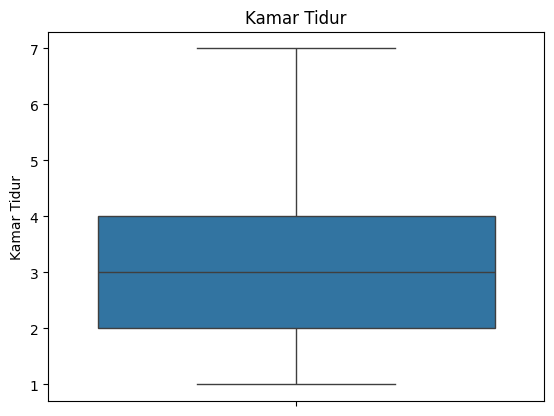

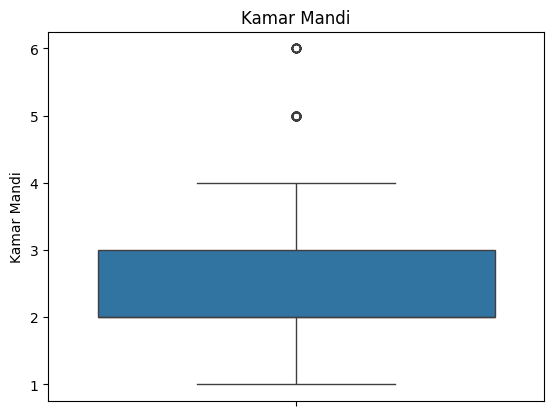

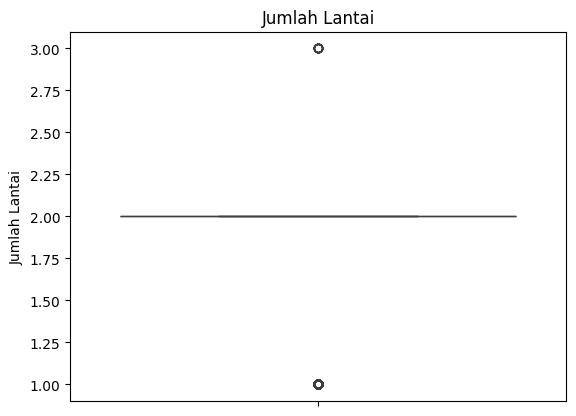

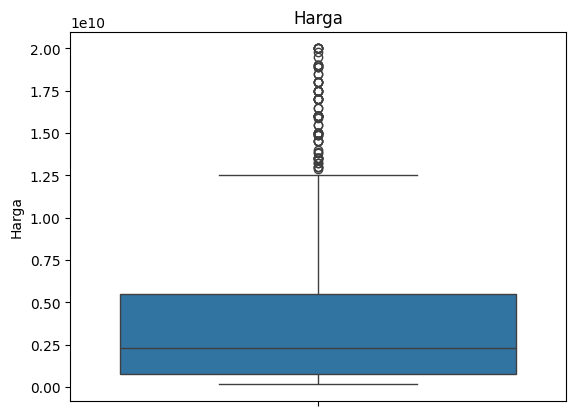

In [ ]:
get_boxplot(jkt_merged)

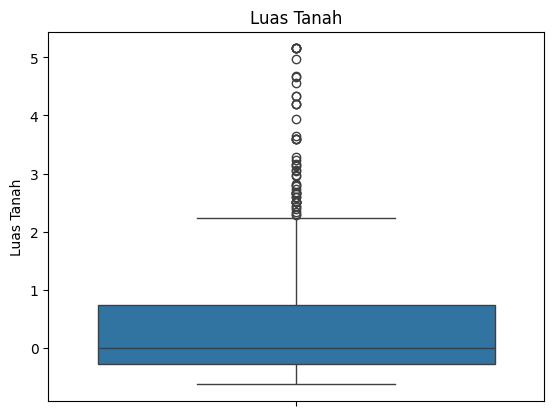

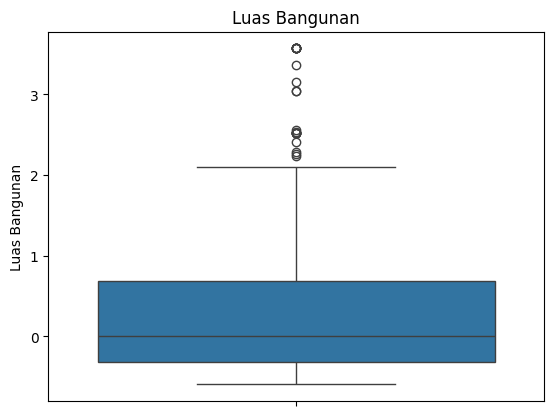

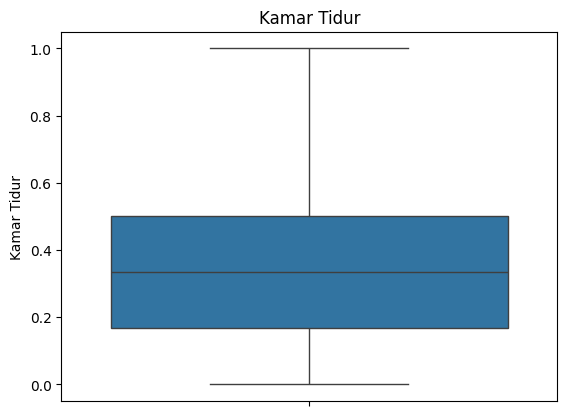

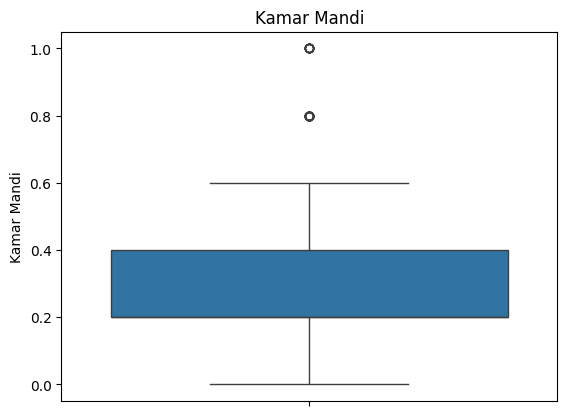

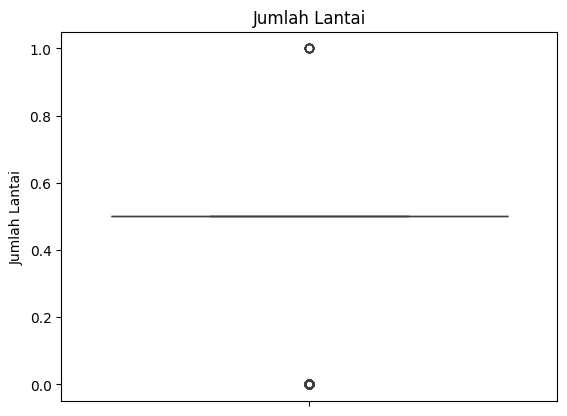

KeyError: 'Harga'

<Figure size 640x480 with 0 Axes>

In [ ]:
get_boxplot(X_train_scaled)

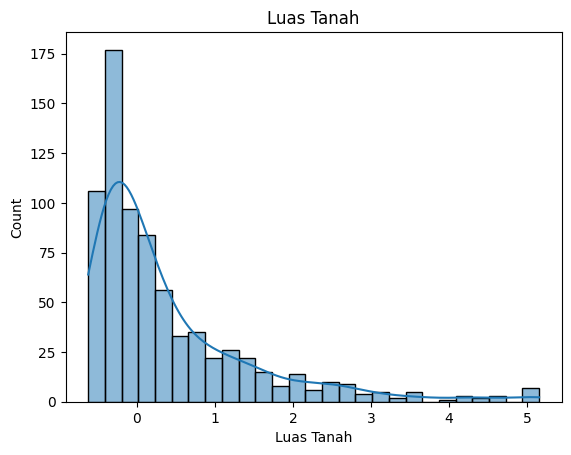

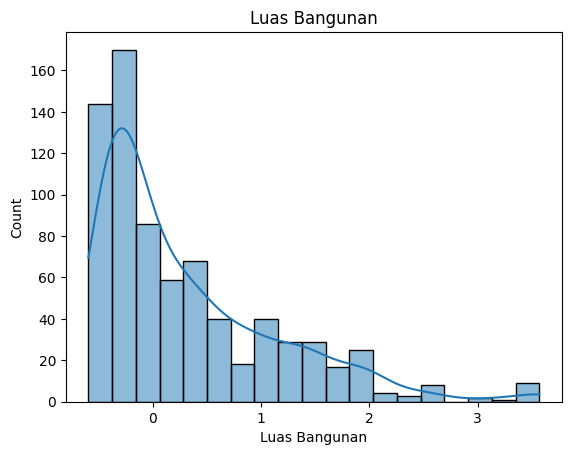

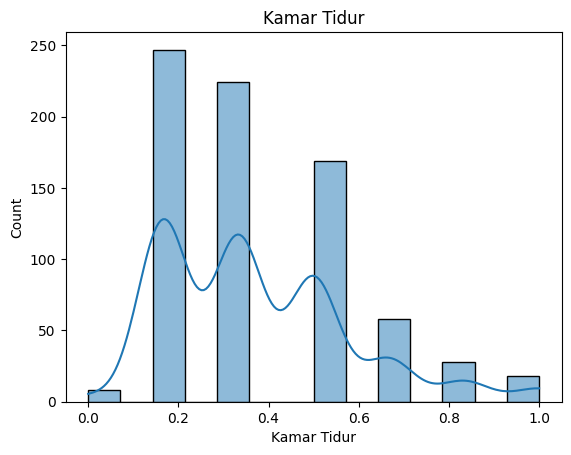

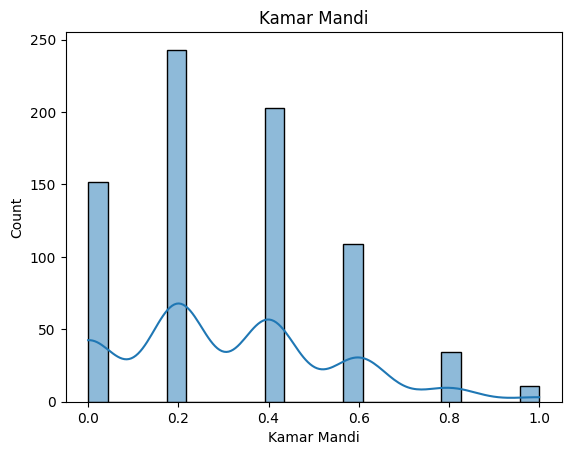

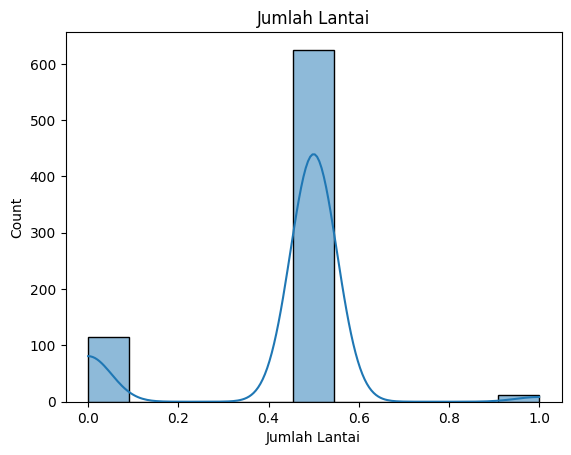

KeyError: 'Harga'

<Figure size 640x480 with 0 Axes>

In [ ]:
get_histplot(X_train_scaled)

In [ ]:
X_train_scaled

Luas Tanah  Luas Bangunan  Kamar Tidur  Kamar Mandi  Jumlah Lantai
82    -0.553571      -0.425197     0.166667          0.2            0.5
314   -0.196429      -0.367454     0.166667          0.2            0.0
916    4.967857       0.367454     0.666667          0.6            0.5
593    1.675000       0.314961     0.500000          0.2            0.5
342   -0.375000      -0.104987     0.166667          0.0            0.0
..          ...            ...          ...          ...            ...
106   -0.267857      -0.393701     0.166667          0.0            0.5
270   -0.196429      -0.367454     0.333333          0.2            0.0
860    1.110714       1.469816     0.333333          0.6            0.5
435    0.075000       0.419948     0.333333          0.0            0.5
102   -0.267857      -0.440945     0.166667          0.0            0.0

[752 rows x 5 columns]

<Axes: ylabel='Harga'>

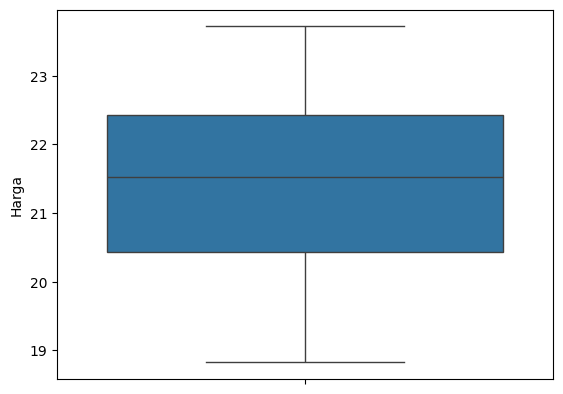

In [ ]:
sns.boxplot(y_train_log)

<Axes: xlabel='Harga', ylabel='Count'>

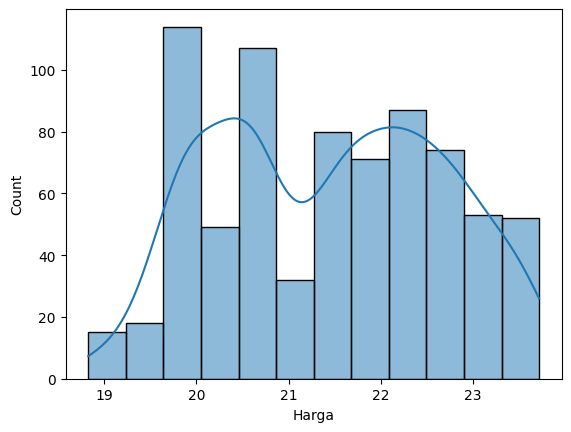

In [ ]:
sns.histplot(y_train_log, kde=True)

#### rfr

In [ ]:
X_jkt_train, X_jkt_test, y_jkt_train, y_jkt_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_jkt_train, y_jkt_train)

RandomForestRegressor()

In [ ]:
rfr.score(X_jkt_test, y_jkt_test)

0.7442218052450968

In [ ]:
get_model_summary(rfr, X_jkt_test, y_jkt_test)

MAE: 1394527042.2720845
MSE: 6.186186622746072e+18
R-squared: 0.7442218052450968

Error for cheapest house: 0.0
Error for most expensive house: 12070100000.0

MAPE: 32.42%


In [ ]:
rfr_scaled = RandomForestRegressor()
rfr_scaled.fit(X_train_scaled, y_train_log)

RandomForestRegressor()

In [ ]:
get_model_summary_scaled(rfr_scaled, X_test_scaled, y_test_log)

MAE: 1343666959.407106
MSE: 5.826951551436648e+18
R-squared: 0.7590749779079328

Error for cheapest house: 7.033348083496094e-06
Error for most expensive house: 11826409314.629942

MAPE: 29.77%


### **Bandung**

In [ ]:
bdg_merged

Luas Tanah  Luas Bangunan  Kamar Tidur  Kamar Mandi  Jumlah Lantai  \
0             60             36            2            1              1   
1             40             30            2            1              1   
2             70             50            2            1              1   
3             70             45            2            1              1   
4             68             36            2            1              1   
...          ...            ...          ...          ...            ...   
1143         520            294            5            2              2   
1144         600            500            6            4              2   
1145         476            500            5            4              2   
1146         911            400            5            5              1   
1147         510            450            4            4              2   

     Category          Harga  nominal  satuan     converted  
0         Low    Rp 175 Juta    175.0    Juta  1.750000e+08  
1         Low    Rp 100 Juta    100.0    Juta  1.000000e+08  
2         Low    Rp 305 Juta    305.0    Juta  3.050000e+08  
3         Low    Rp 285 Juta    285.0    Juta  2.850000e+08  
4         Low    Rp 105 Juta    105.0    Juta  1.050000e+08  
...       ...            ...      ...     ...           ...  
1143   Luxury    Rp 7 Miliar      7.0  Miliar  7.000000e+09  
1144   Luxury   Rp 20 Miliar     20.0  Miliar  2.000000e+10  
1145   Luxury  Rp 8,8 Miliar      8.8  Miliar  8.800000e+09  
1146   Luxury   Rp 15 Miliar     15.0  Miliar  1.500000e+10  
1147   Luxury   Rp 18 Miliar     18.0  Miliar  1.800000e+10  

[1148 rows x 10 columns]

In [ ]:
filt = (bdg_merged['Luas Tanah'] == 1) | (bdg_merged['Luas Bangunan'] == 1)
idx = bdg_merged[filt].index
idx

Index([1018], dtype='int64')

In [ ]:
bdg_merged.drop(index=idx, inplace=True)

In [ ]:
bdg_merged = clean_col(bdg_merged)

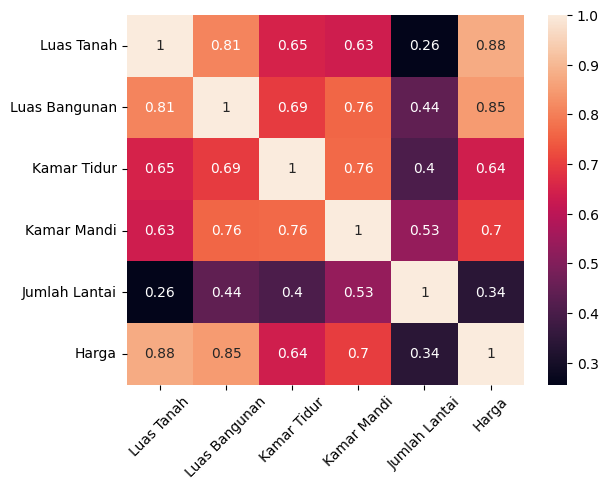

In [ ]:
get_corr(bdg_merged)

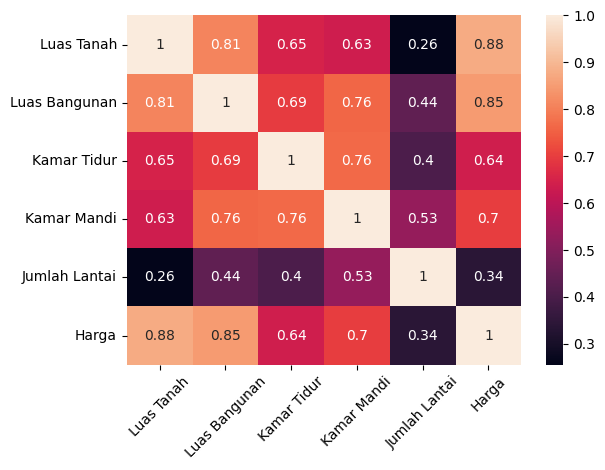

In [ ]:
save_corr(bdg_merged, 'bdg')

<Axes: xlabel='Luas Tanah', ylabel='Harga'>

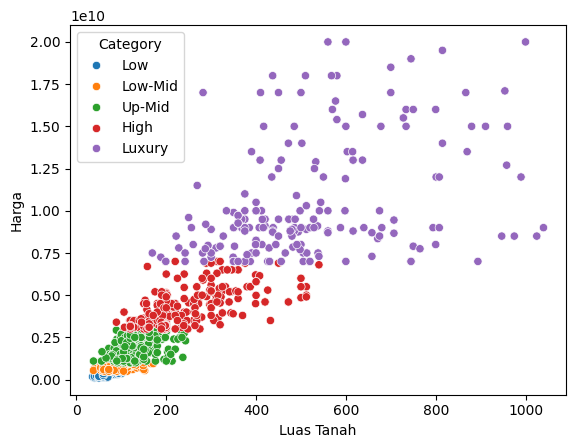

In [ ]:
sns.scatterplot(data=bdg_merged, x='Luas Tanah', y='Harga', hue='Category')

In [ ]:
bdg_robust = RobustScaler()
bdg_minmax = MinMaxScaler()

In [ ]:
X_bdg_train_scaled, X_bdg_test_scaled, y_bdg_train_log, y_bdg_test_log = split_scaled(bdg_merged, bdg_robust, bdg_minmax)

In [ ]:
bdg_xgb =  XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

In [ ]:
bdg_gridsearch = GridSearchCV(
      estimator=bdg_xgb,
      param_grid=param_grid,
      cv=10,
      scoring='neg_mean_squared_error',
      n_jobs=-1,
      verbose=2
  )

In [ ]:
bdg_gridsearch.fit(X_bdg_train_scaled, y_bdg_train_log)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
bdg_bestmodel = bdg_gridsearch.best_estimator_

In [ ]:
get_model_summary_scaled(bdg_bestmodel, X_bdg_test_scaled, y_bdg_test_log)

MAE: 796238993.7391304
MSE: 2.428596313467187e+18
R-squared: 0.8314754055353846

Error for cheapest house: 855423.9999991059
Error for most expensive house: 10104852479.999992

MAPE: 28.69%


In [ ]:
with open('bdg_robust.pkl', 'wb') as f:
  pickle.dump(bdg_robust, f)

with open('bdg_minmax.pkl', 'wb') as f:
  pickle.dump(bdg_minmax, f)

with open('bdg_xgb.pkl', 'wb') as f:
  pickle.dump(bdg_bestmodel, f)

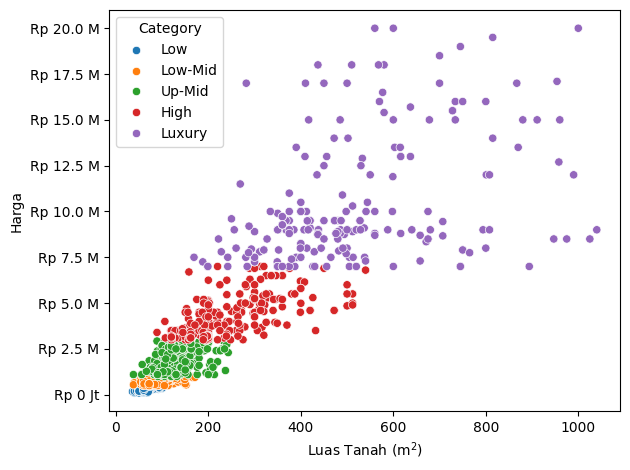

In [ ]:
save_scatter(bdg_merged, 'Luas Tanah', 'Harga', 'bdg_LT')

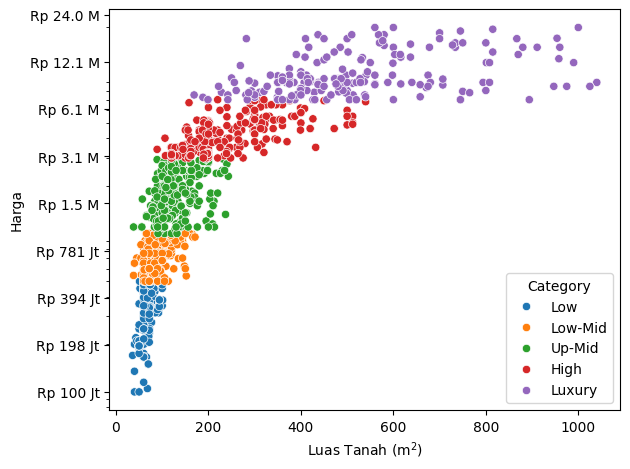

In [ ]:
save_scatterlog(bdg_merged, 'Luas Tanah', 'Harga', 'bdg_LT')

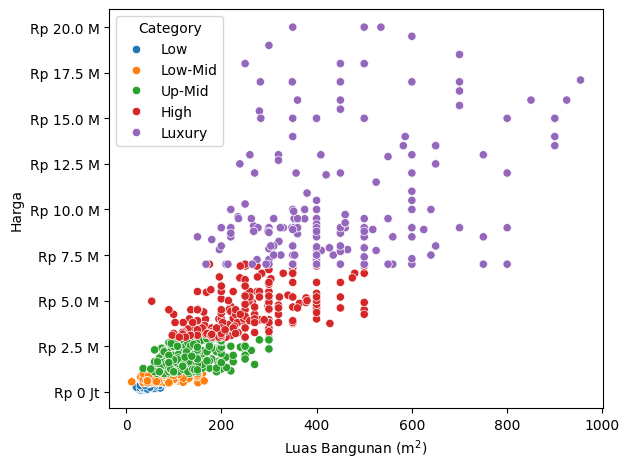

In [ ]:
save_scatter(bdg_merged, 'Luas Bangunan', 'Harga', 'bdg_LB')

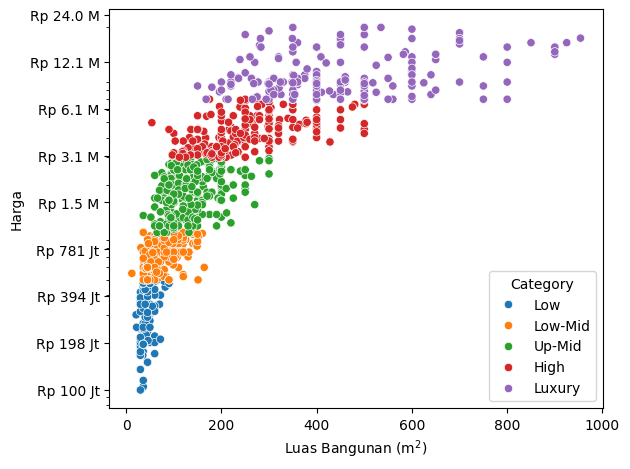

In [ ]:
save_scatterlog(bdg_merged, 'Luas Bangunan', 'Harga', 'bdg_LB')

### **Yogya**

In [ ]:
ygy_merged

Luas Tanah  Luas Bangunan  Kamar Tidur  Kamar Mandi  Jumlah Lantai  \
0            73             38            2            1              1   
1            72             38            2            1              1   
2           125             45            2            1              1   
3            87             36            2            1              1   
4           144             73            2            1              1   
..          ...            ...          ...          ...            ...   
881         698            590            6            5              2   
882         513            400            6            5              2   
883         634            400            6            5              2   
884         500            200            6            5              2   
885        1059            400            6            5              2   

    Category           Harga  nominal  satuan     converted  
0        Low     Rp 411 Juta    411.0    Juta  4.110000e+08  
1        Low     Rp 411 Juta    411.0    Juta  4.110000e+08  
2        Low     Rp 500 Juta    500.0    Juta  5.000000e+08  
3        Low     Rp 350 Juta    350.0    Juta  3.500000e+08  
4        Low     Rp 350 Juta    350.0    Juta  3.500000e+08  
..       ...             ...      ...     ...           ...  
881   Luxury  Rp 12,8 Miliar     12.8  Miliar  1.280000e+10  
882   Luxury   Rp 8,5 Miliar      8.5  Miliar  8.500000e+09  
883   Luxury   Rp 8,5 Miliar      8.5  Miliar  8.500000e+09  
884   Luxury   Rp 7,5 Miliar      7.5  Miliar  7.500000e+09  
885   Luxury   Rp 8,2 Miliar      8.2  Miliar  8.200000e+09  

[886 rows x 10 columns]

In [ ]:
filt = (ygy_merged['Luas Tanah'] == 1) | (ygy_merged['Luas Bangunan'] == 1)
idx = ygy_merged[filt].index
idx

Index([758, 796], dtype='int64')

In [ ]:
ygy_merged.drop(index=idx, inplace=True)

In [ ]:
ygy_merged = clean_col(ygy_merged)

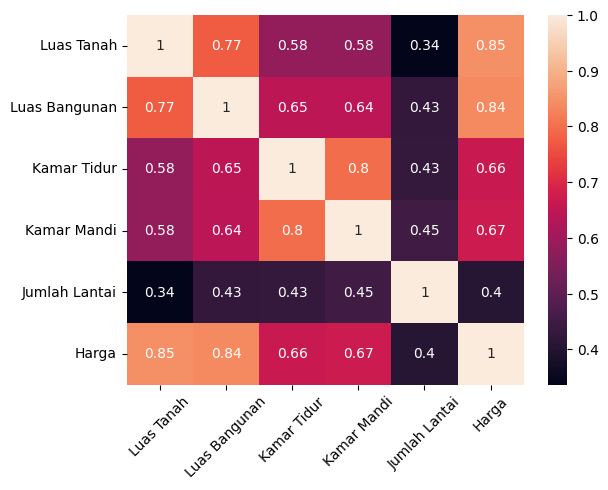

In [ ]:
get_corr(ygy_merged)

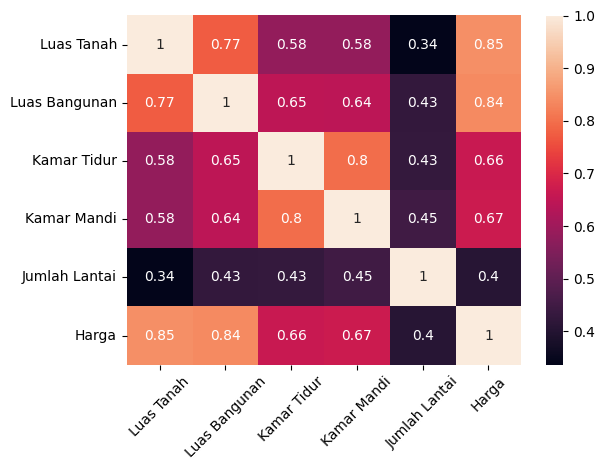

In [ ]:
save_corr(ygy_merged, 'ygy')

<Axes: xlabel='Luas Tanah', ylabel='Harga'>

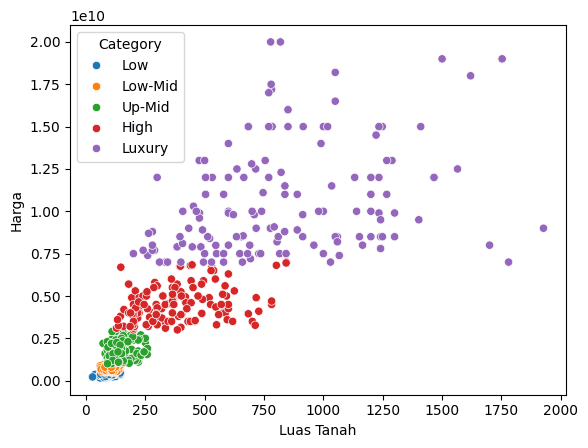

In [ ]:
sns.scatterplot(data=ygy_merged, x='Luas Tanah', y='Harga', hue='Category')

In [ ]:
ygy_robust = RobustScaler()
ygy_minmax = MinMaxScaler()

In [ ]:
X_ygy_train_scaled, X_ygy_test_scaled, y_ygy_train_log, y_ygy_test_log = split_scaled(ygy_merged, ygy_robust, ygy_minmax)

In [ ]:
ygy_xgb =  XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

In [ ]:
ygy_gridsearch = GridSearchCV(
      estimator=ygy_xgb,
      param_grid=param_grid,
      cv=10,
      scoring='neg_mean_squared_error',
      n_jobs=-1,
      verbose=2
  )

In [ ]:
ygy_gridsearch.fit(X_ygy_train_scaled, y_ygy_train_log)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
ygy_bestmodel = ygy_gridsearch.best_estimator_

In [ ]:
get_model_summary_scaled(ygy_bestmodel, X_ygy_test_scaled, y_ygy_test_log)

MAE: 901345013.1525413
MSE: 3.1167811741140076e+18
R-squared: 0.8087210929025087

Error for cheapest house: 3982496.0
Error for most expensive house: 8885971967.999996

MAPE: 25.70%


In [ ]:
with open('ygy_robust.pkl', 'wb') as f:
  pickle.dump(ygy_robust, f)

with open('ygy_minmax.pkl', 'wb') as f:
  pickle.dump(ygy_minmax, f)

with open('ygy_xgb.pkl', 'wb') as f:
  pickle.dump(ygy_bestmodel, f)

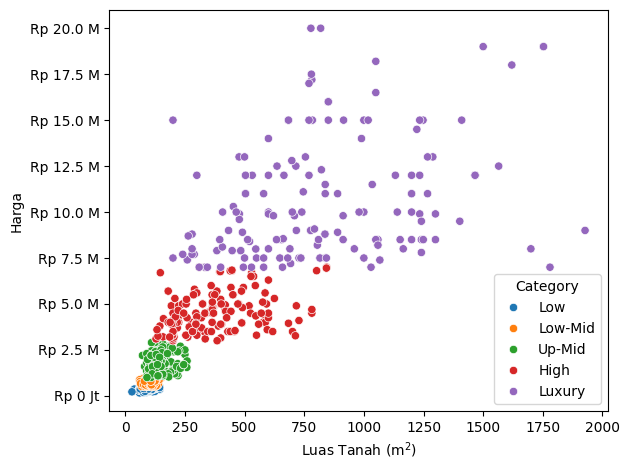

In [ ]:
save_scatter(ygy_merged, 'Luas Tanah', 'Harga', 'ygy_LT')

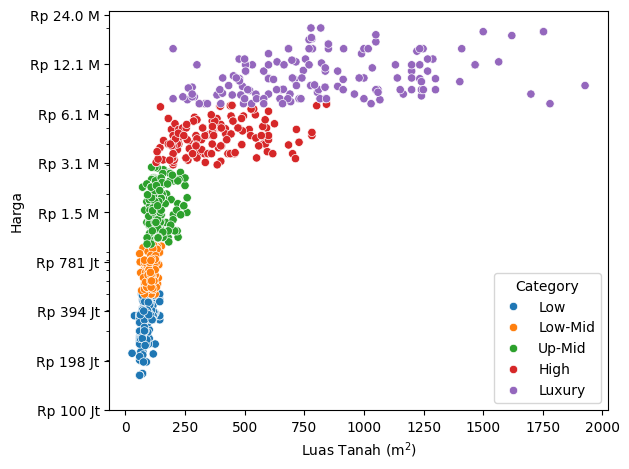

In [ ]:
save_scatterlog(ygy_merged, 'Luas Tanah', 'Harga', 'ygy_LT')

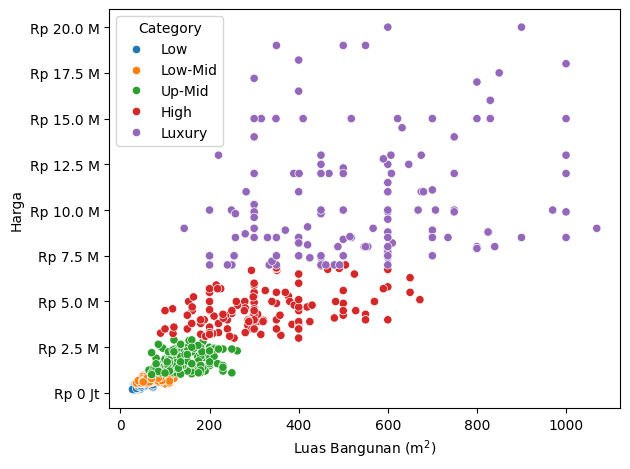

In [ ]:
save_scatter(ygy_merged, 'Luas Bangunan', 'Harga', 'ygy_LB')

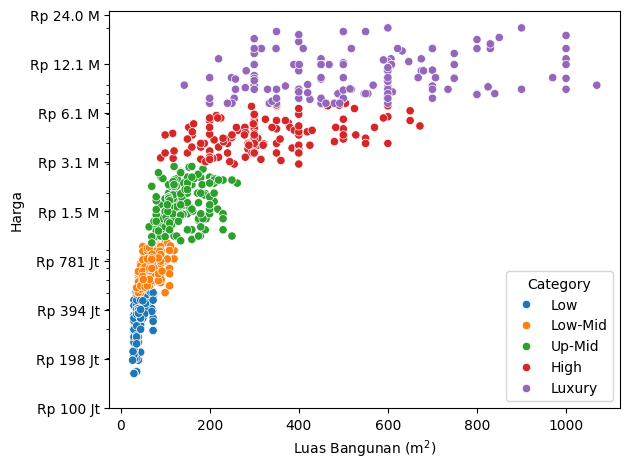

In [ ]:
save_scatterlog(ygy_merged, 'Luas Bangunan', 'Harga', 'ygy_LB')

In [ ]:
filt = (ygy_merged['Category'] == 'Luxury') & (ygy_merged['Luas Bangunan'] < 200)
ygy_merged[filt]

Luas Tanah  Luas Bangunan  Kamar Tidur  Kamar Mandi  Jumlah Lantai  \
746         433            143           11           11              2   

    Category         Harga  
746   Luxury  9.000000e+09

### **Surabaya**

In [ ]:
sby_merged

Luas Tanah  Luas Bangunan  Kamar Tidur  Kamar Mandi  Jumlah Lantai  \
0            120            100            2            1              1   
1            120             90            2            1              1   
2            120             10            2            1              1   
3            120             90            2            1              1   
4             24             19            2            1              1   
...          ...            ...          ...          ...            ...   
1124         126            200            8            4              1   
1125         369            550            4            4              1   
1126         450            500            6            3              2   
1127         375            550            4            4              2   
1128         312            470            5            5              2   

     Category           Harga  nominal  satuan     converted  
0         Low     Rp 150 Juta   150.00    Juta  1.500000e+08  
1         Low     Rp 254 Juta   254.00    Juta  2.540000e+08  
2         Low     Rp 482 Juta   482.00    Juta  4.820000e+08  
3         Low     Rp 254 Juta   254.00    Juta  2.540000e+08  
4         Low     Rp 335 Juta   335.00    Juta  3.350000e+08  
...       ...             ...      ...     ...           ...  
1124   Luxury    Rp 10 Miliar    10.00  Miliar  1.000000e+10  
1125   Luxury   Rp 7,9 Miliar     7.90  Miliar  7.900000e+09  
1126   Luxury  Rp 10,5 Miliar    10.50  Miliar  1.050000e+10  
1127   Luxury   Rp 7,3 Miliar     7.30  Miliar  7.300000e+09  
1128   Luxury  Rp 7,75 Miliar     7.75  Miliar  7.750000e+09  

[1129 rows x 10 columns]

In [ ]:
filt = (sby_merged['Luas Tanah'] == 1) | (sby_merged['Luas Bangunan'] == 1)
sby_merged[filt]

Empty DataFrame
Columns: [Luas Tanah, Luas Bangunan, Kamar Tidur, Kamar Mandi, Jumlah Lantai, Category, Harga, nominal, satuan, converted]
Index: []

In [ ]:
sby_merged[sby_merged['Category'] == 'Luxury'].min()

Luas Tanah                126
Luas Bangunan             100
Kamar Tidur                 1
Kamar Mandi                 1
Jumlah Lantai               1
Category               Luxury
Harga            Rp 10 Miliar
nominal                   7.0
satuan                   Juta
converted        1750000000.0
dtype: object

In [ ]:
filt = (sby_merged['Category'] == 'Luxury') & (sby_merged['Luas Tanah'] == 126) & (sby_merged['Luas Bangunan'] == 100)
sby_merged[filt]

Empty DataFrame
Columns: [Luas Tanah, Luas Bangunan, Kamar Tidur, Kamar Mandi, Jumlah Lantai, Category, Harga, nominal, satuan, converted]
Index: []

In [ ]:
filt = (sby_merged['Luas Tanah'] == 126) & (sby_merged['Luas Bangunan'] == 100) & (sby_merged['converted'] == 1750000000.0)
sby_merged[filt]

Empty DataFrame
Columns: [Luas Tanah, Luas Bangunan, Kamar Tidur, Kamar Mandi, Jumlah Lantai, Category, Harga, nominal, satuan, converted]
Index: []

In [ ]:
filt = sby_merged['Category'] == 'Luxury'
filt = (sby_merged['converted'] == sby_merged.loc[filt, 'converted'].min())
sby_merged.loc[filt]

Luas Tanah  Luas Bangunan  Kamar Tidur  Kamar Mandi  Jumlah Lantai  \
472          75            100            3            3              2   
553          75            120            3            2              2   
566         108            160            3            3              2   
567         135            200            6            3              2   
573          75            100            3            3              2   
613          75            100            3            3              2   
615          75            100            3            3              2   
623         140             90            2            2              1   
626          90            200            6            3              2   
627         135            126            3            3              1   
628         135            126            4            3              1   
641          75            115            3            3              2   
645          75            115            3            3              2   
648          75            115            3            3              2   
694         200             60            2            1              1   
934         220            300            4            4              2   

    Category           Harga  nominal  satuan     converted  
472   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
553   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
566   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
567   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
573   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
613   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
615   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
623   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
626   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
627   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
628   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
641   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
645   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
648   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
694   Up-Mid  Rp 1,75 Miliar     1.75  Miliar  1.750000e+09  
934   Luxury     Rp 7,1 Juta     7.10    Juta  1.750000e+09

In [ ]:
sby_merged.loc[934]

Luas Tanah                220
Luas Bangunan             300
Kamar Tidur                 4
Kamar Mandi                 4
Jumlah Lantai               2
Category               Luxury
Harga             Rp 7,1 Juta
nominal                   7.1
satuan                   Juta
converted        1750000000.0
Name: 934, dtype: object

In [ ]:
sby_merged.drop(index=934, inplace=True)

In [ ]:
sby_merged = clean_col(sby_merged)

In [ ]:
sby_merged.shape

(1128, 7)

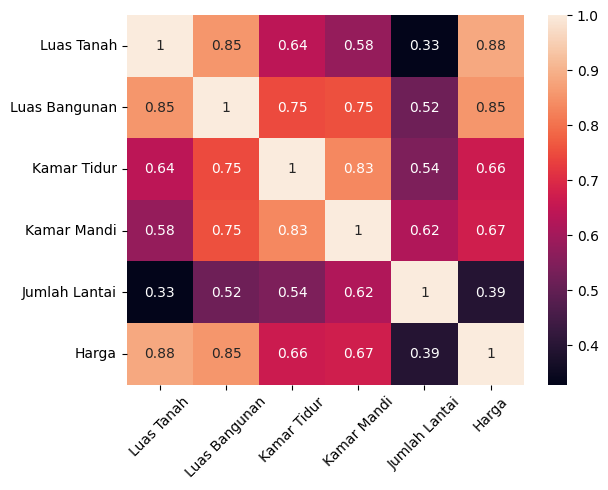

In [ ]:
get_corr(sby_merged)

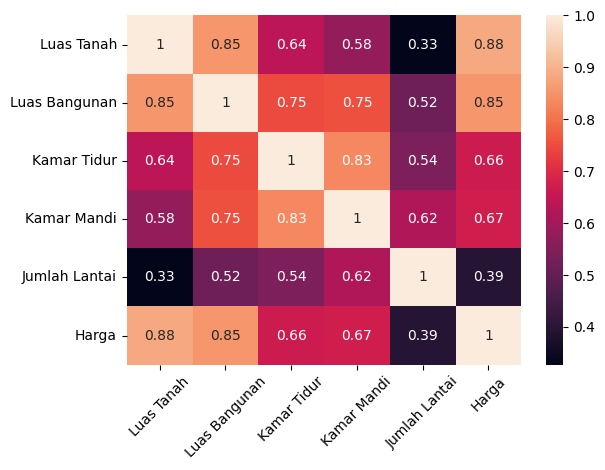

In [ ]:
save_corr(sby_merged, 'sby')

<Axes: xlabel='Luas Tanah', ylabel='Harga'>

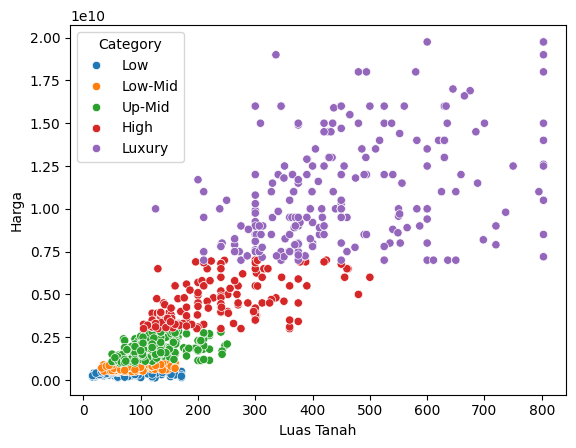

In [ ]:
sns.scatterplot(data=sby_merged, x='Luas Tanah', y='Harga', hue='Category')

In [ ]:
sby_robust = RobustScaler()
sby_minmax = MinMaxScaler()

In [ ]:
X_sby_train_scaled, X_sby_test_scaled, y_sby_train_log, y_sby_test_log = split_scaled(sby_merged, sby_robust, sby_minmax)

In [ ]:
sby_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

In [ ]:
sby_gridsearch = GridSearchCV(
      estimator=sby_xgb,
      param_grid=param_grid,
      cv=10,
      scoring='neg_mean_squared_error',
      n_jobs=-1,
      verbose=2
  )

In [ ]:
sby_gridsearch.fit(X_sby_train_scaled, y_sby_train_log)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
sby_bestmodel = sby_gridsearch.best_estimator_

In [ ]:
get_model_summary_scaled(sby_bestmodel, X_sby_test_scaled, y_sby_test_log)

MAE: 774815436.8849552
MSE: 2.26372881791733e+18
R-squared: 0.8504809483509452

Error for cheapest house: 3035583.9999991655
Error for most expensive house: 7399331328.00001

MAPE: 27.07%


In [ ]:
with open('sby_robust.pkl', 'wb') as f:
  pickle.dump(sby_robust, f)

with open('sby_minmax.pkl', 'wb') as f:
  pickle.dump(sby_minmax, f)

with open('sby_xgb.pkl', 'wb') as f:
  pickle.dump(sby_bestmodel, f)

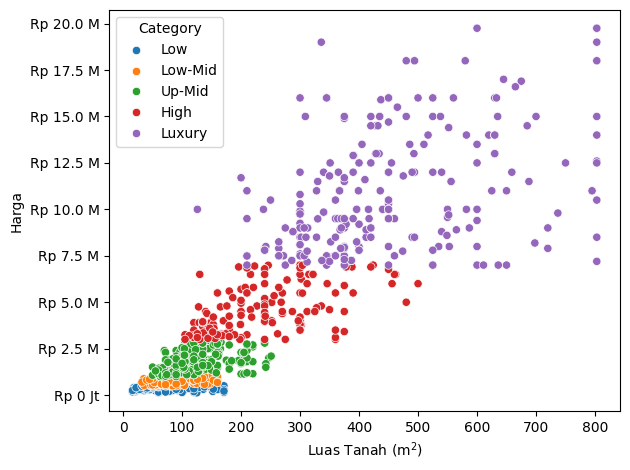

In [ ]:
save_scatter(sby_merged, 'Luas Tanah', 'Harga', 'sby_LT')

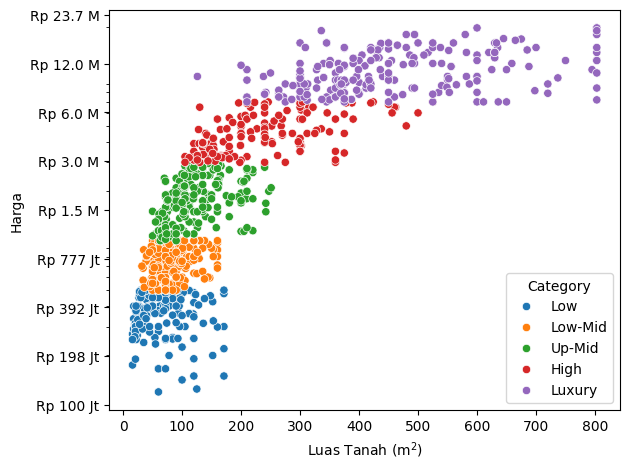

In [ ]:
save_scatterlog(sby_merged, 'Luas Tanah', 'Harga', 'sby_LT')

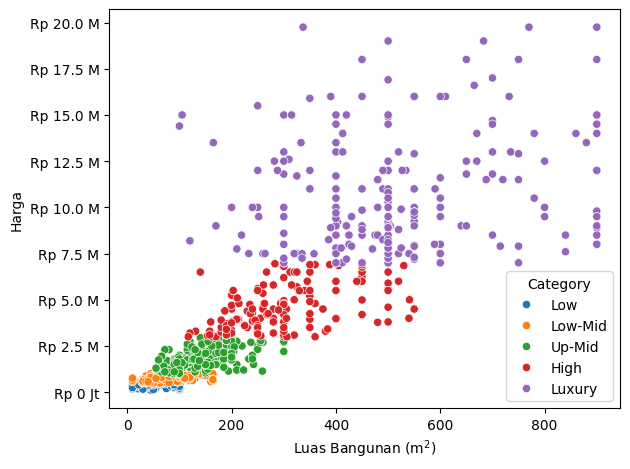

In [ ]:
save_scatter(sby_merged, 'Luas Bangunan', 'Harga', 'sby_LB')

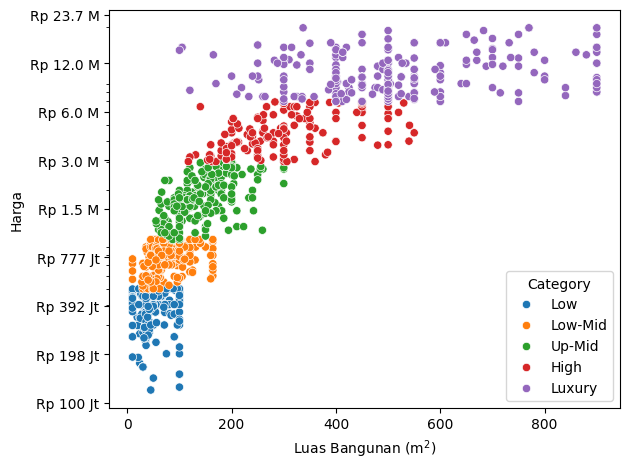

In [ ]:
save_scatterlog(sby_merged, 'Luas Bangunan', 'Harga', 'sby_LB')

In [ ]:
filt = (sby_merged['Category'] == 'Luxury') & (sby_merged['Luas Bangunan'] < 400)
sby_merged[filt]

Luas Tanah  Luas Bangunan  Kamar Tidur  Kamar Mandi  Jumlah Lantai  \
883          803            310            1            1              2   
890          480            300            4            4              2   
892          210            358            5            5              2   
907          600            333            3            3              2   
912          340            250            4            3              1   
913          460            252            5            3              1   
916          400            300            3            2              1   
920          272            325            3            4              2   
923          400            300            3            2              1   
926          312            300            5            4              2   
931          460            320            6            3              2   
938          494            350            6            3              1   
942          435            105            3            2              1   
943          486            165            3            2              1   
953          582            250            4            2              2   
965          435            105            3            2              1   
973          437            350            5            3              2   
981          600            337            4            4              1   
985          210            335            5            5              2   
987          600            300            4            4              1   
1002         552            100            1            1              1   
1005         375            233            4            3              2   
1007         698            120            1            1              2   
1019         307            170            4            3              1   
1020         200            325            4            5              1   
1021         351            282            4            3              2   
1024         465            250            4            3              1   
1026         465            250            4            3              1   
1037         238            240            2            4              1   
1050         399            350            1            1              1   
1053         650            350            2            2              1   
1054         803            219            4            1              2   
1061         475            300            1            1              1   
1062         360            260            6            3              1   
1063         360            260            6            3              1   
1066         264            264            5            4              1   
1067         560            390            5            3              1   
1071         337            335            5            4              2   
1072         375            300            3            2              1   
1076         549            300            5            4              1   
1077         450            300            4            3              1   
1080         474            210            4            2              1   
1089         396            386            8            3              2   
1096         368            390            4            3              2   
1097         429            300            8            5              2   
1099         286            300            4            4              2   
1110         309            315            2            2              1   
1115         450            288            5            6              2   
1124         126            200            8            4              1   

     Category         Harga  
883    Luxury  1.260000e+10  
890    Luxury  1.500000e+10  
892    Luxury  7.490000e+09  
907    Luxury  1.350000e+10  
912    Luxury  1.200000e+10  
913    Luxury  9.500000e+

### **Bali**

In [ ]:
bali_merged

Luas Tanah  Luas Bangunan  Kamar Tidur  Kamar Mandi  Jumlah Lantai  \
0             60             60            2            1              1   
1             60             33            2            1              1   
2             80             45            2            1              1   
3            100             30            2            1              1   
4             90             36            2            1              1   
...          ...            ...          ...          ...            ...   
1258         500            443            4            3              2   
1259         350            436            4            2              2   
1260         405            600            4            4              2   
1261         375            133            4            3              2   
1262         266            250            6            4              2   

     Category           Harga  nominal  satuan     converted  
0         Low     Rp 328 Juta    328.0    Juta  3.280000e+08  
1         Low     Rp 328 Juta    328.0    Juta  3.280000e+08  
2         Low     Rp 315 Juta    315.0    Juta  3.150000e+08  
3         Low     Rp 350 Juta    350.0    Juta  3.500000e+08  
4         Low     Rp 180 Juta    180.0    Juta  1.800000e+08  
...       ...             ...      ...     ...           ...  
1258   Luxury  Rp 12,5 Miliar     12.5  Miliar  1.250000e+10  
1259   Luxury    Rp 16 Miliar     16.0  Miliar  1.600000e+10  
1260   Luxury   Rp 8,8 Miliar      8.8  Miliar  8.800000e+09  
1261   Luxury    Rp 16 Miliar     16.0  Miliar  1.600000e+10  
1262   Luxury     Rp 8 Miliar      8.0  Miliar  8.000000e+09  

[1263 rows x 10 columns]

In [ ]:
filt = (bali_merged['Luas Bangunan'] == 1) | (bali_merged['Luas Tanah'] == 1)
bali_merged[filt]

Empty DataFrame
Columns: [Luas Tanah, Luas Bangunan, Kamar Tidur, Kamar Mandi, Jumlah Lantai, Category, Harga, nominal, satuan, converted]
Index: []

In [ ]:
bali_merged = clean_col(bali_merged)

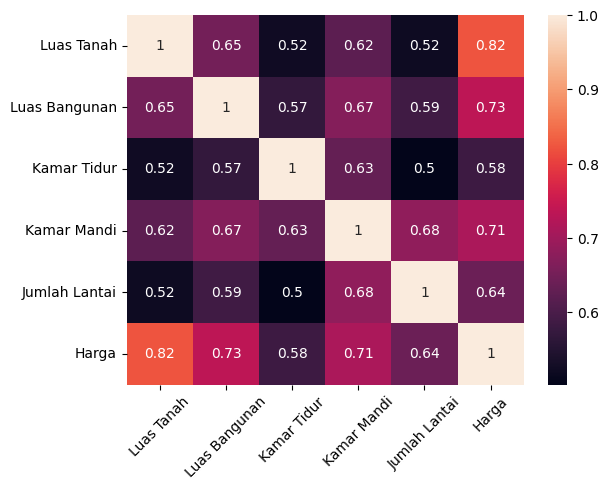

In [ ]:
get_corr(bali_merged)

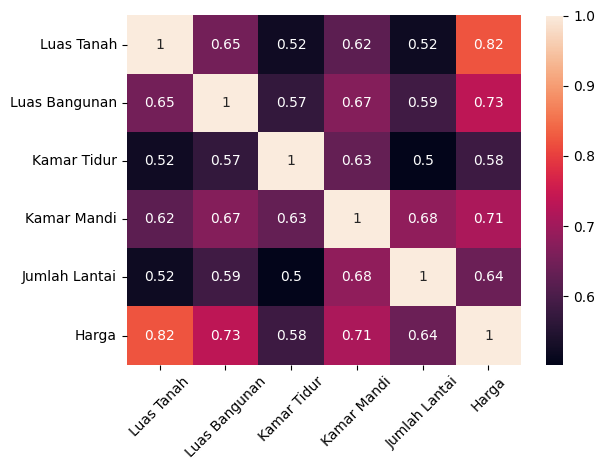

In [ ]:
save_corr(bali_merged, 'bali')

<Axes: xlabel='Luas Tanah', ylabel='Harga'>

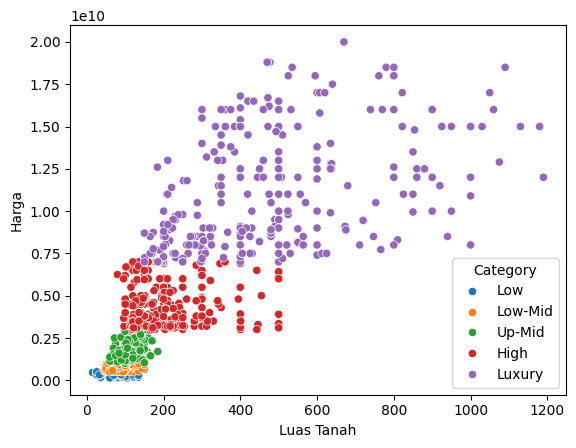

In [ ]:
sns.scatterplot(data=bali_merged, x='Luas Tanah', y='Harga', hue='Category')

In [ ]:
bali_robust = RobustScaler()
bali_minmax = MinMaxScaler()

In [ ]:
X_bali_train_scaled, X_bali_test_scaled, y_bali_train_log, y_bali_test_log = split_scaled(bali_merged, bali_robust, bali_minmax)

In [ ]:
bali_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

In [ ]:
bali_gridsearch = GridSearchCV(
      estimator=bali_xgb,
      param_grid=param_grid,
      cv=10,
      scoring='neg_mean_squared_error',
      n_jobs=-1,
      verbose=2
  )

In [ ]:
bali_gridsearch.fit(X_bali_train_scaled, y_bali_train_log)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
bali_bestmodel = bali_gridsearch.best_estimator_

In [ ]:
get_model_summary_scaled(bali_bestmodel, X_bali_test_scaled, y_bali_test_log)

MAE: 1312058391.2094853
MSE: 5.321511121346149e+18
R-squared: 0.763509813380439

Error for cheapest house: 222720.0000013113
Error for most expensive house: 9564387839.99997

MAPE: 30.50%


In [ ]:
with open('bali_robust.pkl', 'wb') as f:
  pickle.dump(bali_robust, f)

with open('bali_minmax.pkl', 'wb') as f:
  pickle.dump(bali_minmax, f)

with open('bali_xgb.pkl', 'wb') as f:
  pickle.dump(bali_bestmodel, f)

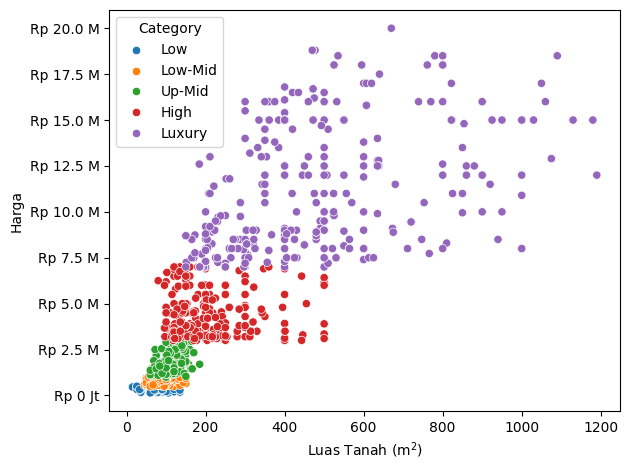

In [ ]:
save_scatter(bali_merged, 'Luas Tanah', 'Harga', 'bali_LT')

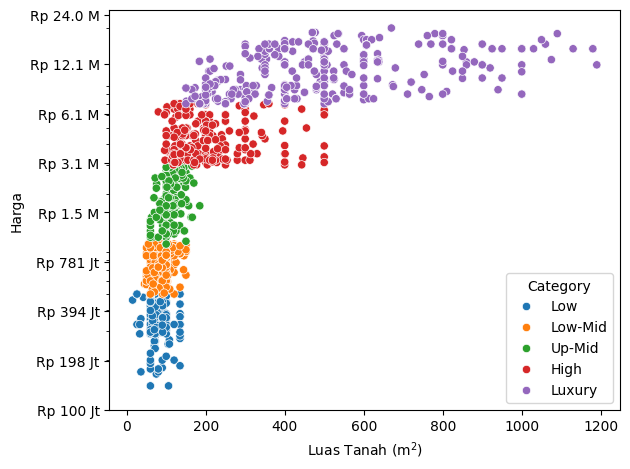

In [ ]:
save_scatterlog(bali_merged, 'Luas Tanah', 'Harga', 'bali_LT')

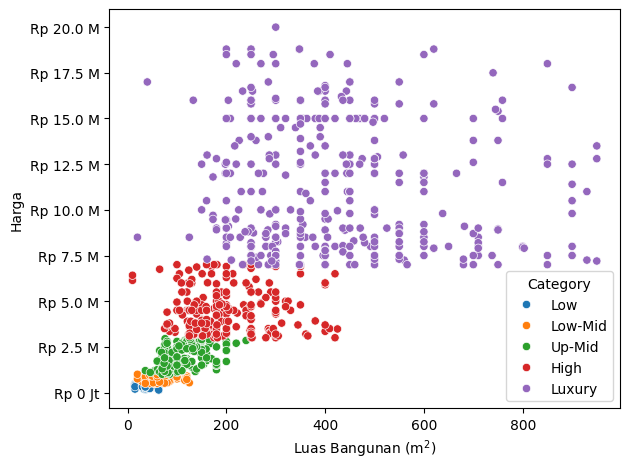

In [ ]:
save_scatter(bali_merged, 'Luas Bangunan', 'Harga', 'bali_LB')

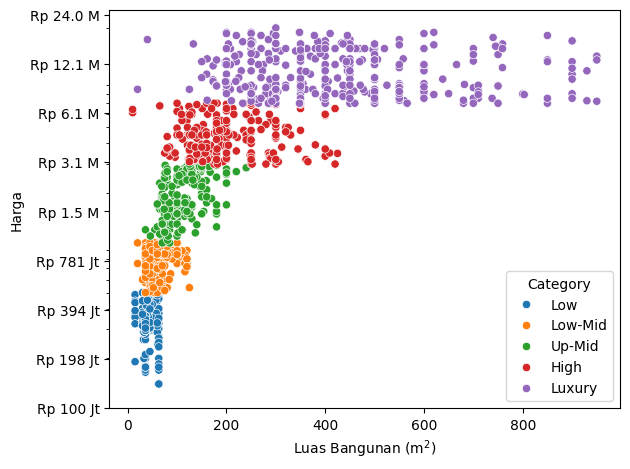

In [ ]:
save_scatterlog(bali_merged, 'Luas Bangunan', 'Harga', 'bali_LB')